In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, log_loss

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

## Problem setting & description
This dataset is from a controlled experiment, where sensors are used to observe changes in environmental variables when number of people in a room fluctuate between zero and three.<br>
In total, seven different sensors were installed into a 6m x 4.6m room.

Dataset obtained from:
https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation

Classification will be performed on this data, with **logistic regression** and **multi-layer perceptron** chosen as methods.

In [2]:
# load data from csv
df = pd.read_csv('Occupancy_Estimation_0-3.csv')
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

## Exploratory analysis and feature selection
As detailed previously, there are no null values in this dataset. Therefore at this point, all rows can be considered valid for the analysis unless further exploratory analysis reveals strange outliers or otherwise invalid variable values.

Next we'll explore the features type by type.

### Date and Time

In [4]:
df[['Hour', 'rest']] = df['Time'].str.split(pat=':', n=1, expand=True)
df.drop(['rest'], axis=1, inplace=True)
df['Hour'] = df['Hour'].astype('int')
df['Time'].value_counts()

10:49:41    1
21:43:16    1
21:39:42    1
21:40:13    1
21:40:43    1
           ..
16:31:37    1
16:32:07    1
16:32:38    1
16:33:09    1
09:00:09    1
Name: Time, Length: 10129, dtype: int64

<AxesSubplot:ylabel='Frequency'>

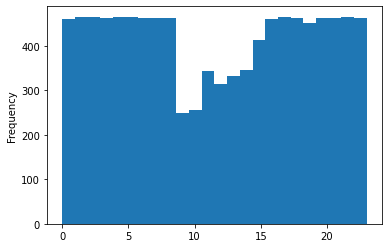

In [5]:
df['Hour'].plot(kind='hist', bins=24)

In [6]:
if 'Date' in df.columns and 'Time' in df.columns:
    df.drop(['Date', 'Time', 'Hour'], axis=1, inplace=True)

The data has been collected in a controlled manner, date and time should not have an impact on room occupancy count. We can see that for the most part, time (hour) is distributed quite uniformally which supports this notion. Therefore it is decided that for purpose of this analysis, time and date information is deemed irrelevant. 

Even if time would somewhat correlate to room occupancy in this experiment, this information would not translate to new data as, again, the room occupancy is controlled by the researchers.

### Target: Room_Occupancy_Count

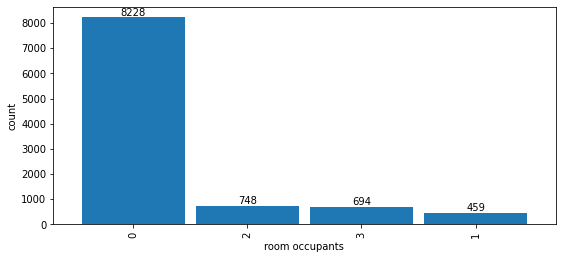

In [7]:
ax = df['Room_Occupancy_Count'].value_counts().plot(kind = 'bar', figsize=(9, 4), width=0.9)
for container in ax.containers:
    ax.bar_label(container)
plt.ylabel('count')
plt.xlabel('room occupants')
plt.show()

We can see that the data is quite imbalanced, with zero occupants (=empty room) occupying most of the observations. We'll take this into account later on when building the ML model. 
As the target value can take one of four distinct values, this is a **multiclass classification problem**. The distribution of target values other than zero, is a lot more balanced.

### Temperature (S1_Temp, S2_Temp, S3_Temp, S4_Temp)
The room is fitted with four temperature sensors, spaced evenly from each other. We check if all the sensors report similar data.

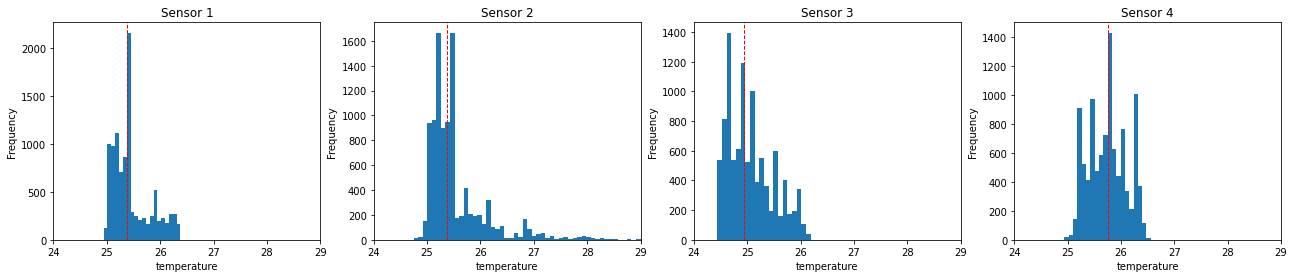

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(22,4))
df['S1_Temp'].plot(kind='hist', ax=ax[0], bins=20)
ax[0].axvline(df['S1_Temp'].median(), color='red', linestyle='dashed', linewidth=1)
ax[0].set_xlim([24,29])
ax[0].set_xlabel('temperature')
ax[0].set_title('Sensor 1')

df['S2_Temp'].plot(kind='hist', ax=ax[1], bins=50)
ax[1].axvline(df['S2_Temp'].median(), color='red', linestyle='dashed', linewidth=1)
ax[1].set_xlim([24,29])
ax[1].set_xlabel('temperature')
ax[1].set_title('Sensor 2')

df['S3_Temp'].plot(kind='hist', ax=ax[2], bins=20)
ax[2].axvline(df['S3_Temp'].median(), color='red', linestyle='dashed', linewidth=1)
ax[2].set_xlim([24,29])
ax[2].set_xlabel('temperature')
ax[2].set_title('Sensor 3')

df['S4_Temp'].plot(kind='hist', ax=ax[3], bins=20)
ax[3].axvline(df['S4_Temp'].median(), color='red', linestyle='dashed', linewidth=1)
ax[3].set_xlim([24,29])
ax[3].set_xlabel('temperature')
ax[3].set_title('Sensor 4')

plt.show()

Interestingly, the sensors report quite different temperatures compared to each other.<br>
The median temperature is around 25 to 26 degrees for all the sensors, but only sensor 2 reports readings higher than 26.5 degrees.<br>
Similarly only sensor 3 consistently gives readings closer to 24 degrees on the low end (which also skews the median towards lower values) - the others bottom at around 25 degrees.

### Light (S1_Light, S2_Light, S3_Light, S4_Light)
The light levels are monitored by the same four sensors as in the previous step. Light levels are measured and reported in lux.

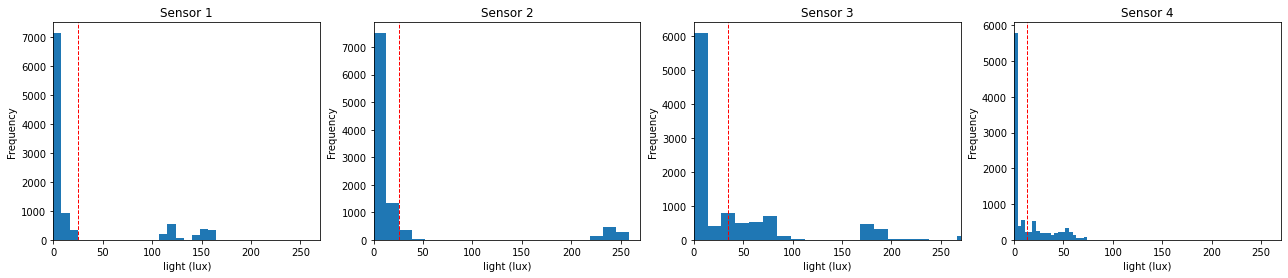

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(22,4))
df['S1_Light'].plot(kind='hist', ax=ax[0], bins=20)
ax[0].axvline(df['S1_Light'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[0].set_xlim([0,270])
ax[0].set_xlabel('light (lux)')
ax[0].set_title('Sensor 1')

df['S2_Light'].plot(kind='hist', ax=ax[1], bins=20)
ax[1].axvline(df['S2_Light'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[1].set_xlim([0,270])
ax[1].set_xlabel('light (lux)')
ax[1].set_title('Sensor 2')

df['S3_Light'].plot(kind='hist', ax=ax[2], bins=20)
ax[2].axvline(df['S3_Light'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[2].set_xlim([0,270])
ax[2].set_xlabel('light (lux)')
ax[2].set_title('Sensor 3')

df['S4_Light'].plot(kind='hist', ax=ax[3], bins=20)
ax[3].axvline(df['S4_Light'].mean(), color='red', linestyle='dashed', linewidth=1)
ax[3].set_xlim([0,270])
ax[3].set_xlabel('light (lux)')
ax[3].set_title('Sensor 4')

plt.show()

As the room is empty for the most part of the experiment, it would be logical that an empty room has light levels closer to zero (in this experiment). <br>
Possible explanation for rising light levels when the room is occupied could be windows with curtains, lights being switched on or even a door being opened to a brightly lit space. 

### Sound (S1_Sound, S2_Sound, S3_Sound, S4_Sound)

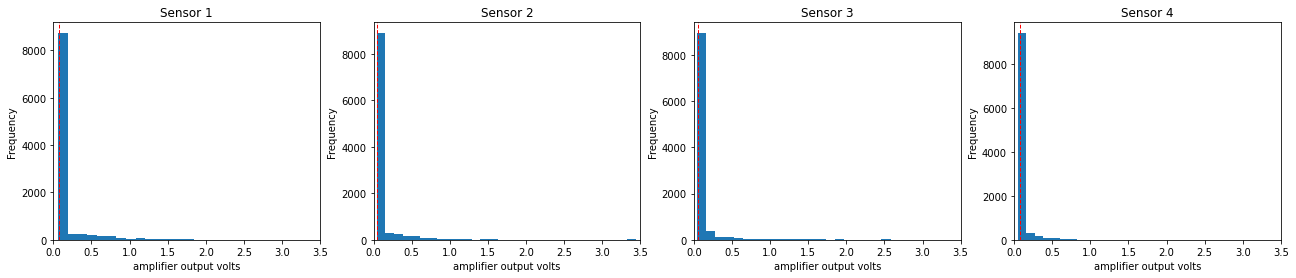

Min sound S1: 0.06, Median: 0.08
Min sound S2: 0.04, Median: 0.05
Min sound S3: 0.04, Median: 0.06
Min sound S4: 0.05, Median: 0.08


In [10]:
fig, ax = plt.subplots(1, 4, figsize=(22,4))
df['S1_Sound'].plot(kind='hist', ax=ax[0], bins=30)
ax[0].axvline(df['S1_Sound'].median(), color='red', linestyle='dashed', linewidth=1)
ax[0].set_xlim([0,3.5])
ax[0].set_xlabel('amplifier output volts')
ax[0].set_title('Sensor 1')

df['S2_Sound'].plot(kind='hist', ax=ax[1], bins=30)
ax[1].axvline(df['S2_Sound'].median(), color='red', linestyle='dashed', linewidth=1)
ax[1].set_xlim([0,3.5])
ax[1].set_xlabel('amplifier output volts')
ax[1].set_title('Sensor 2')

df['S3_Sound'].plot(kind='hist', ax=ax[2], bins=30)
ax[2].axvline(df['S3_Sound'].median(), color='red', linestyle='dashed', linewidth=1)
ax[2].set_xlim([0,3.5])
ax[2].set_xlabel('amplifier output volts')
ax[2].set_title('Sensor 3')

df['S4_Sound'].plot(kind='hist', ax=ax[3], bins=30)
ax[3].axvline(df['S4_Sound'].median(), color='red', linestyle='dashed', linewidth=1)
ax[3].set_xlim([0,3.5])
ax[3].set_xlabel('amplifier output volts')
ax[3].set_title('Sensor 4')

plt.show()
print('Min sound S1: {}, Median: {}'.format(df['S1_Sound'].min(), df['S1_Sound'].median()))
print('Min sound S2: {}, Median: {}'.format(df['S2_Sound'].min(), df['S2_Sound'].median()))
print('Min sound S3: {}, Median: {}'.format(df['S3_Sound'].min(), df['S3_Sound'].median()))
print('Min sound S4: {}, Median: {}'.format(df['S4_Sound'].min(), df['S4_Sound'].median()))

The sound data from all sensors is distributed very similarly. A hypothesis would be that in a small room sensors pick up sounds at a similar level irrespective of the exact location.

### CO2, CO2 slope & PIR
These sensors observe CO2 levels and detected motion.

CO2 is reported in two ways, the current CO2 level (ppm) and CO2 slope, meaning a slope of CO2 readings taken in a sliding window (negative means decreasing values, positive increasing)<br>
Motion is reported using a binary variable, either there is motion detected (value of 1) or there is not (value of 0).

Minimum CO2 level: 345ppm
Maximum CO2 level: 1270ppm


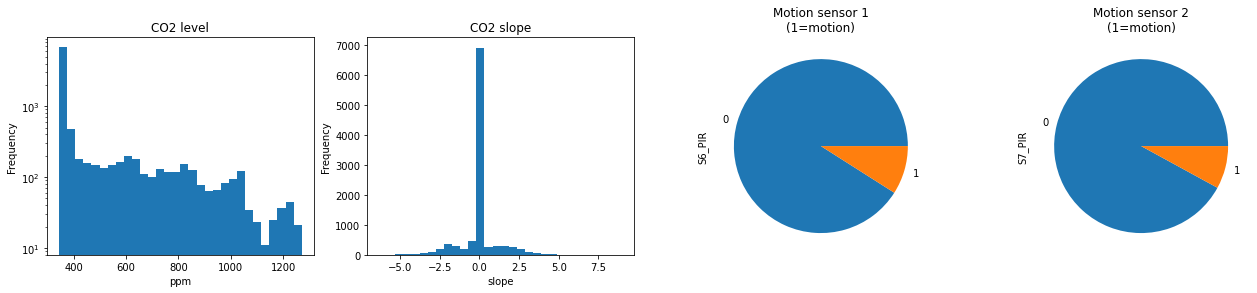

In [11]:
print('Minimum CO2 level: {}ppm'.format(df['S5_CO2'].min()))
print('Maximum CO2 level: {}ppm'.format(df['S5_CO2'].max()))

fig, ax = plt.subplots(1, 4, figsize=(22,4))
df['S5_CO2'].plot(kind='hist', bins=30, ax=ax[0], log=True)
ax[0].set_xlabel('ppm')
ax[0].set_title('CO2 level')

df['S5_CO2_Slope'].plot(kind='hist', bins=30, ax=ax[1])
ax[1].set_xlabel('slope')
ax[1].set_title('CO2 slope')

df['S6_PIR'].value_counts().plot(kind='pie', ax=ax[2])
ax[2].set_title('Motion sensor 1\n(1=motion)')
df['S7_PIR'].value_counts().plot(kind='pie', ax=ax[3])
ax[3].set_title('Motion sensor 2\n(1=motion)')
plt.show()

## Feature engineering
As logistic regression and MLP are sensitive to feature scale, and we previously observed clear differences between the scales (even between different sensors observing the same data!), we apply standard scaling to the features before running the ML model.<br> This is done as a first step of the pipeline. Same scaling is also applied to the testing data when predicting results.

Further eature engineering is not needed since we don't have e.g. any categorical variables that need encoding.

## ML Models

**Target** = Room occupancy count<br>
**Features** = all other variables

We split the data into training and test sets, where test set size is 15%. Further splitting to validation sets is done in the next step.

In [12]:
y = df['Room_Occupancy_Count']
X = df.loc[:, df.columns != 'Room_Occupancy_Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Logistic Regression

We use a simple grid search for searching the hyperparameters for logistic regression. GridSearchCV uses k-fold cross validation for defining validation sets.
 - **C-values**: *100*, *10*, *1*, *0.1* and *0.01* are tested.
 - **Class weight**: *None* and *balanced*

In [43]:
# Define model hyperparameters
# https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
solvers = ['lbfgs']
c_values = [100, 10, 1, 0.1, 0.01]
class_weights = [None, 'balanced']
grid = dict(
    solver=solvers, 
    C=c_values, 
    class_weight=class_weights
    )

# Build pipeline with scaling, grid search and logistic regression
pipeline = make_pipeline(
    StandardScaler(), 
    GridSearchCV(
        estimator=LogisticRegression(max_iter=10000),
        param_grid=grid,
        cv=3,
        scoring='neg_log_loss',
        refit=True)
    )

# Fit training data
pipeline.fit(X_train, y_train)

# Get best params
print('Best model parameters:')
print(pipeline.named_steps['gridsearchcv'].best_params_)
print(pipeline.named_steps['gridsearchcv'].best_score_)

Best model parameters:
{'C': 10, 'class_weight': None, 'solver': 'lbfgs'}
-0.02329520901484007


In [44]:
# Predict
y_pred = pipeline.predict(X_test)

# Compute train & test loss
train_loss_logreg = log_loss(y_train, pipeline.predict_proba(X_train))
test_loss_logreg = log_loss(y_test, pipeline.predict_proba(X_test))
val_loss_logreg = -pipeline.named_steps['gridsearchcv'].best_score_

# Compute accuracy, precision and recall
acc_logreg = accuracy_score(y_test, y_pred)
prec_logreg = precision_score(y_test, y_pred, average='macro')
rec_logreg = recall_score(y_test, y_pred, average='macro')

print('\nTest set:')
print('Accuracy:  {:.4f}'.format(acc_logreg))
print('Precision: {:.4f}'.format(prec_logreg))
print('Recall:    {:.4f}'.format(rec_logreg))


Test set:
Accuracy:  0.9928
Precision: 0.9761
Recall:    0.9795


### Multi-layer perceptron (MLP)


The MLP model is constructed using a similar pipeline. StandardScaler is used to standardize data and a grid search is used to identify best performing hyperparameters.
 - Trying different activation function
 - Various hidden layer sizes

In [42]:
# Define model hyperparameters
solver = ['adam']
activation = ['relu', 'tanh']
hidden_layer_sizes = [(100,), (50,50,50), (100,50,10)]
grid = dict(
    solver=solver, 
    activation=activation, 
    hidden_layer_sizes=hidden_layer_sizes
    )

pipeline_mlp = make_pipeline(
    StandardScaler(), 
    GridSearchCV(
        estimator=MLPClassifier(random_state=42, max_iter=300),
        param_grid=grid,
        cv=3,
        scoring='neg_log_loss',
        refit=True)
    )

# Fit training data
pipeline_mlp.fit(X_train, y_train)

# Get best params
print('Best model parameters:')
print(pipeline_mlp.named_steps['gridsearchcv'].best_params_)
print(pipeline_mlp.named_steps['gridsearchcv'].best_score_)

Best model parameters:
{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
-0.017911113848003132


In [45]:
# Predict test set
y_pred_mlp = pipeline_mlp.predict(X_test)

# Compute train & test loss
train_loss_mlp = log_loss(y_train, pipeline_mlp.predict_proba(X_train))
test_loss_mlp = log_loss(y_test, pipeline_mlp.predict_proba(X_test))
val_loss_mlp = -pipeline_mlp.named_steps['gridsearchcv'].best_score_

# Compute accuracy, precision and recall
acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp, average='macro')
rec_mlp = recall_score(y_test, y_pred_mlp, average='macro')

print('\nTest set:')
print('Accuracy:  {:.4f}'.format(acc_mlp))
print('Precision: {:.4f}'.format(prec_mlp))
print('Recall:    {:.4f}'.format(rec_mlp))


Test set:
Accuracy:  0.9934
Precision: 0.9767
Recall:    0.9834


### Results and model comparison
Comparing the two models on unseen test data with the use of confusion matrices and summary metrics

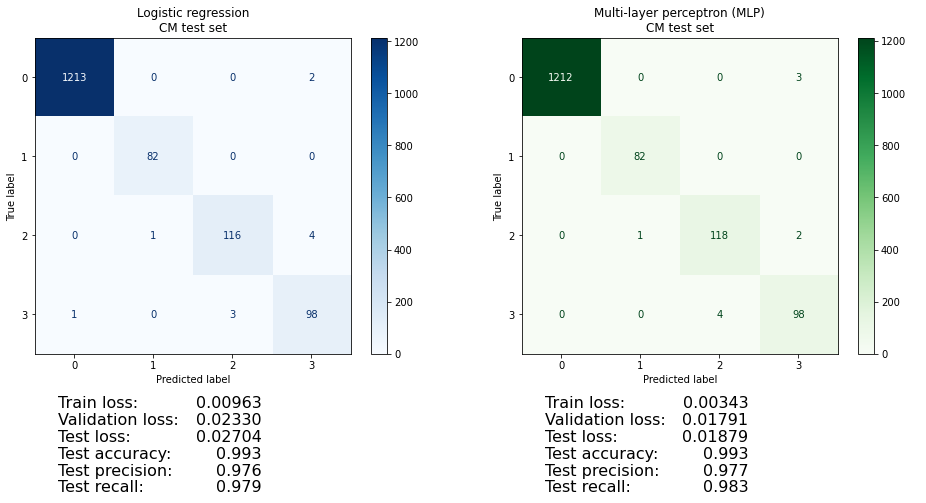

In [50]:
# create figure, axes
fig, ax = plt.subplots(2, 2, figsize=(16,8), gridspec_kw={'height_ratios': [4, 1]})

# cm logreg
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues', ax=ax[0, 0])
ax[0, 0].set_title('Logistic regression\nCM test set')

# cm mlp
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=pipeline_mlp.classes_)
disp = ConfusionMatrixDisplay(cm_mlp, display_labels=pipeline_mlp.classes_)
disp.plot(cmap='Greens', ax=ax[0, 1])
ax[0, 1].set_title('Multi-layer perceptron (MLP)\nCM test set')

# logreg stats
ax[1,0].set_axis_off()
table_l = ax[1,0].table(
    cellText = [['{:.5f}'.format(train_loss_logreg)],
                ['{:.5f}'.format(val_loss_logreg)],
                ['{:.5f}'.format(test_loss_logreg)],
                ['{:.3f}'.format(acc_logreg)],
                ['{:.3f}'.format(prec_logreg)],
                ['{:.3f}'.format(rec_logreg)]],
    rowLabels = ['Train loss:', 'Validation loss:', 'Test loss:', 'Test accuracy:', 'Test precision:', 'Test recall:'],
    colWidths = [0.2, 0.3],
    edges = '',
    loc = 'upper center'
    )
table_l.set_fontsize(16)
table_l.scale(1, 1.4)

# mlp stats
ax[1,1].set_axis_off()
table_m = ax[1,1].table(
    cellText = [['{:.5f}'.format(train_loss_mlp)],
                ['{:.5f}'.format(val_loss_mlp)],
                ['{:.5f}'.format(test_loss_mlp)],
                ['{:.3f}'.format(acc_mlp)],
                ['{:.3f}'.format(prec_mlp)],
                ['{:.3f}'.format(rec_mlp)]],
    rowLabels = ['Train loss:', 'Validation loss:', 'Test loss:', 'Test accuracy:', 'Test precision:', 'Test recall:'],
    colWidths = [0.2, 0.3],
    edges = '',
    loc = 'upper center',
    )
table_m.set_fontsize(16)
table_m.scale(1, 1.4)

# show plot
plt.show()

The performance of both models is exceptionally good, which would imply that the features are clearly and consistently correlated with the label values.<br>This leads to the ML problem being very easy for these models to learn on.

Even though both model perform very similarly, misclassifying only few samples, the multi-layer perceptron implementation performs slightly better by every metric shown here, especially the training, validation and testing losses. Additionally, the validation and test losses of the MLP model are very similar which indicates that the model performs almost equally well on unseen data. On the other hand, the test loss of the logistic regression model is relatively higher than the validation loss, which tells us that there might be some overfitting and that the model does not perform as well on new data as the MLP model does.

Therefore, for this exact problem, it would be advisable to choose the MLP model over the logistic regression implementation.